# *Name of tutorial* with FACET

***

**Robust and impactful Data Science with FACET**

FACET enables us to perform several critical steps in best practice Data Science work flow easily, efficiently and reproducibly:

1. Create a robust pipeline for learner selection using LearnerRanker and cross-validation.

2. Enhance our model inspection to understand drivers of predictions using local explanations of features via [SHAP values](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) by applying a novel methodology that decomposes SHAP values into measures of synergy, redundancy, and independence between each pair of features.

3. Quickly apply historical simulation to gain key insights into feature values that minimize or maximize the predicted outcome.

***

**Context**

This tutorial aims to provide a step by step explanation about the simultion capabilities of Facet

1. The tutorial will answer several quesitons such as: How does a simulation work? or When can I/can't I use it?
2. Drilling a water well is very dangerous and costly. The costs of such drilling are driven by the time it takes to finalize a well in order to start pumping water from it. To reduce those costs, drillers are usually incentivized to drill at a faster pace—measured as the Rate of Penetration (ROP). Depending on soil characteristics, day rates can range from 30,000 to \$250,000. But there is a trade-off: Drilling faster increases the risk of incidents, such as a formation collapse or a gas infiltration. We will therefore built a machine-learning model to understand the impact of drilling speed on the incident risk, in the context of other risk factors. 

For the sake of clarity, we use a simplified dataset for this example. The dataset contains 500 observations, with each row representing a drilling operation of the past, along with a binary indicator of whether or not a well-drilling incident happened in the operation. 


***

**Tutorial outline**

1. [Required imports](#Required-imports)
2. [*Your sections*](#Your-sections)  
... *more of your sections*

3. [Summary](#Summary)
4. [What can you do next?](#What-can-you-do-next?)
5. [Appendix](#Appendix)

#TODO repeat the nb with UnivariateUpliftSimulator or UnivariateTargetSimulator

In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx


def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os

    if "cwd" not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")


def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook

    # ignore a useless LGBM warning
    import warnings

    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")


_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings


import matplotlib.pyplot as plt


def _configure_matplotlib():
    # set global options for matplotlib

    import matplotlib

    matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
    matplotlib.rcParams["figure.dpi"] = 72


_configure_matplotlib()

del _configure_matplotlib

working dir is '/Users/grisard_malo/PycharmProjects/githubFacet/facet'
added `/Users/grisard_malo/PycharmProjects/githubFacet/pytools/src` to python paths
added `/Users/grisard_malo/PycharmProjects/githubFacet/facet/src` to python paths
added `/Users/grisard_malo/PycharmProjects/githubFacet/sklearndf/src` to python paths


# Required imports

In order to run this notebook, we will import not only the FACET package, but also other packages useful to solve this task. Overall, we can break down the imports into three categories: 

1. Common packages (pandas, matplotlib, etc.)
2. Required FACET classes (inspection, selection, validation, simulation, etc.)
3. Other BCG Gamma packages which simplify pipelining (sklearndf, see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)) and support visualization (pytools, see on [GitHub](https://github.com/BCG-Gamma/pytools)) when using FACET

**Common package imports**

In [2]:
# list your usual imports here such as pandas, numpy and others 
# not covered by FACET, sklearndf or pytools
import numpy as np
import pandas as pd
import seaborn as sns

**Gamma FACET imports**

In [3]:
from facet.data import Sample
from facet.validation import BootstrapCV
from facet.simulation.partition import (ContinuousRangePartitioner, 
IntegerRangePartitioner, CategoryPartitioner)
from facet.simulation import UnivariateProbabilitySimulator
from facet.simulation.viz import SimulationDrawer
from facet.crossfit import LearnerCrossfit

**sklearndf imports**

Instead of using the "regular" scikit-learn package, we are going to use sklearndf (see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)). sklearndf is an open source library designed to address a common issue with scikit-learn: the outputs of transformers are numpy arrays, even when the input is a data frame. However, to inspect a model it is essential to keep track of the feature names. sklearndf retains all the functionality available through scikit-learn plus the feature traceability and usability associated with Pandas data frames. Additionally, the names of all your favourite scikit-learn functions are the same except for `DF` on the end. For example, the standard scikit-learn import:

`from sklearn.pipeline import Pipeline`

becomes:

`from sklearndf.pipeline import PipelineDF`

In [4]:
from sklearndf.pipeline import ClassifierPipelineDF
from sklearndf.classification.extra import LGBMClassifierDF

**pytools imports**

pytools (see on [GitHub](https://github.com/BCG-Gamma/pytools)) is an open source library containing general machine learning and visualization utilities, some of which are useful for visualising the advanced model inspection capabilities of FACET.

In [5]:
# list your pytools imports here

# *Your sections*

1. *Your text providing an overview of this section.*
2. *Use as many sections as you need to provide a good high-level structure to the tutorial, such as preprocessing, classifier development or model inspection*

Based on the water well drilling tutorial, we select a feature set allmost linearly independent with the ROP (Rate of Penetration)

In [6]:
df = pd.read_csv(
    "sphinx/source/tutorial/water_drill_data_classification.csv",
    sep=";",
    encoding="utf-8",
)

feature_set = ['Weight on bit (kg)', 'Rotation speed (rpm)',
               'Depth of operation (m)', 'Mud density (kg/L)',
               'Rate of Penetration (ft/h)', 'Hole diameter (m)']
drilling_obs = Sample(observations=df, 
                      target_name="Incident", 
                      feature_names=feature_set)

In [7]:
drilling_obs.features.head()

feature,Weight on bit (kg),Rotation speed (rpm),Depth of operation (m),Mud density (kg/L),Rate of Penetration (ft/h),Hole diameter (m)
observation,,,,,,
0,306.141821,9849.952938,927.968837,2.902467,10.000000,6.373932
1,324.039405,10744.516916,1106.187754,2.106770,32.898796,7.507640
2,345.377055,5393.241061,898.168085,3.909455,22.723761,6.180673
3,356.709497,6776.865696,769.165223,2.473607,25.168914,5.368265
4,328.437275,6024.116387,215.202605,3.033681,18.921436,2.092908


# Partitioning

The first step to simulate feature effects on the target is to set the scope of the study for the feature we want to simulate. Depending on the feature observations distribution, a partitioner object will set lower and upper boundaries to fix the simulation scope.

The partitioner creates a set of partition values $v_j \in V$ that are later used one after the other in simulation.

Facet has three variations of partitioner available depending on the feature type, ContinuousRangePartitioner, IntegerRangePartitioner and CategoryPartitioner
-	If the feature is categorical, the partitioner will create a partition for each unique value $v_j$


-	If the feature is numerical (continuous), the partitioner will subdivide feature range of values into equidistant sub-ranges. Each partition will be represented by the central value of the sub-range. Each partition is represented by the central value of that partition $v_j$.


-	If the feature is numerical  (integer), the partitioner will subdivide feature range of values into almost equidistant sub-ranges keeping the bin boundaries integers. Each partition will be represented by the central value of the sub-range potentially disrupting sub-ranges. Each partition is represented by the central value of that partition $v_j$.

In [8]:
SIM_FEATURE = "Rate of Penetration (ft/h)"

## Observing the data distribution

The plot below shows that the ROP values $O_i$ of the dataset are centered around 24 ft/hr with a variance around 22ft/h.

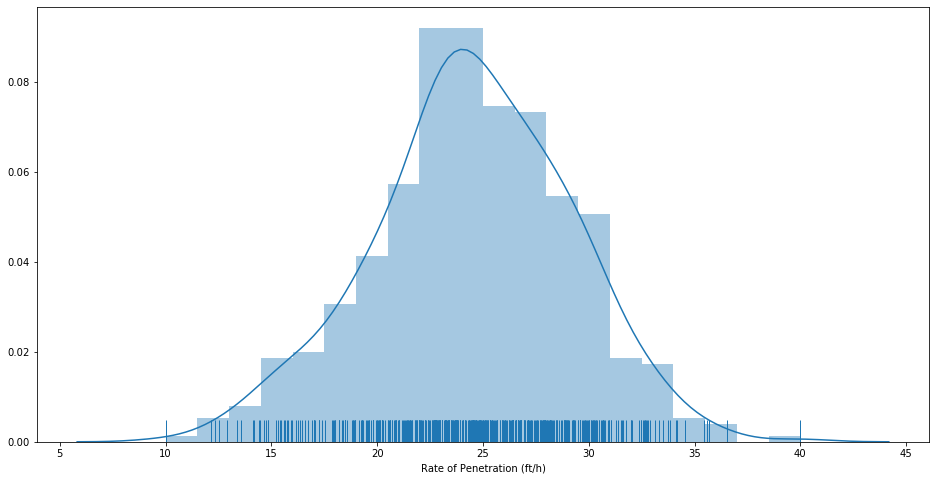

In [9]:
sns.distplot(drilling_obs.features[SIM_FEATURE], rug=True)

## Partitioning the data

The ROP is a continuous variable (measured in ft/h) hence we should use the *ContinuousRangePartitioner* object.

In [10]:
# Instantiate the partitioner
rop_bins = ContinuousRangePartitioner()

# Fit the partitioner on the observations' distribution
rop_bins.fit(drilling_obs.features[SIM_FEATURE])
rop_bins.is_fitted()

True

In [11]:
# One can observe that bounds are continuous, try changing the partitioner
# to an IntegerRangePartitioner and observe that partition become integers
rop_bins.partition_bounds_

[(14.5, 15.5),
 (15.5, 16.5),
 (16.5, 17.5),
 (17.5, 18.5),
 (18.5, 19.5),
 (19.5, 20.5),
 (20.5, 21.5),
 (21.5, 22.5),
 (22.5, 23.5),
 (23.5, 24.5),
 (24.5, 25.5),
 (25.5, 26.5),
 (26.5, 27.5),
 (27.5, 28.5),
 (28.5, 29.5),
 (29.5, 30.5),
 (30.5, 31.5),
 (31.5, 32.5),
 (32.5, 33.5)]

The partition set $V$ can be seen below

In [12]:
rop_bins.partitions_

[15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0]

# Simulating one partition

For each partition value $v_j$, we will compute several simulations to get a sense of how and how much the feature value impacts the target. 

Two pre-requisites are needed to run the simulation:
- Have the sample of observations
- Have a parametrized model

Steps to run a simulation for ROP=$v_j$
- Step 1: set up cross-fit method, for simulations it is standard to use bootstrap as a cross validation with a relatively large number of resamples (~1000)

## Pre-requisites
From the water drilling tutorial classifiers' experiment, we know that the best model is an LGBM classifier, hence we choose this model for our simulation.

In [13]:
# light gradient boosting learner
lgbm_clf = ClassifierPipelineDF(
    classifier=LGBMClassifierDF(random_state=42, min_data_in_leaf=15),
)

## Step 1: Set up crossfit

The crossfit is built by using a cross-validation method to fit several learners (all using the model parametrized), each using a specific split.

Below is an example with 3 splits. One can observe the random resampling from bootstrappiing, the first observation ($O_0$) would be in the test set of two folds while the third observation ($O_2$) would never occur in the test set.

In [14]:
# EXAMPLE CELL
# Instantiate cross validation method
cv = BootstrapCV(n_splits=3, random_state=42)

# Take a small sub-sample from the dataset (to show an example)
example_sample = drilling_obs.subsample(iloc=range(10))

for train_index, test_index in cv.split(example_sample.features, example_sample.target):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [6 3 7 4 6 9 2 6 7 4] TEST: [0 1 5 8]
TRAIN: [3 7 7 2 5 4 1 7 5 1] TEST: [0 6 8 9]
TRAIN: [4 0 9 5 8 0 9 2 6 3] TEST: [1 7]


In [19]:
# Instantiate the crossfit
boot_crossfit = LearnerCrossfit(
    pipeline=lgbm_clf,
    cv=BootstrapCV(n_splits=10, random_state=42),
    n_jobs=1,
    verbose=1,
)

One can observe that a model has been trained for each boostrap fold. 

In [16]:
# Fit the model
boot_crossfit.fit(sample=drilling_obs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s finished


In [24]:
for learner in boot_crossfit.models():
    print(f"Check learner is fitted: {learner}, is fitted: {learner.is_fitted}")

Check learner is fitted: ClassifierPipelineDF(classifier=LGBMClassifierDF(min_data_in_leaf=15,
                                                 random_state=42)), is fitted: True
Check learner is fitted: ClassifierPipelineDF(classifier=LGBMClassifierDF(min_data_in_leaf=15,
                                                 random_state=42)), is fitted: True
Check learner is fitted: ClassifierPipelineDF(classifier=LGBMClassifierDF(min_data_in_leaf=15,
                                                 random_state=42)), is fitted: True
Check learner is fitted: ClassifierPipelineDF(classifier=LGBMClassifierDF(min_data_in_leaf=15,
                                                 random_state=42)), is fitted: True
Check learner is fitted: ClassifierPipelineDF(classifier=LGBMClassifierDF(min_data_in_leaf=15,
                                                 random_state=42)), is fitted: True
Check learner is fitted: ClassifierPipelineDF(classifier=LGBMClassifierDF(min_data_in_leaf=15,
          

## Calibrate simulation

As our model is a classifier (the model estimates a probability to have an incident), we will use a UnivariateProbabilitySimulator. 



In [25]:
# Instantiate simulator
rop_simulator = UnivariateProbabilitySimulator(crossfit=boot_crossfit, 
                                               n_jobs=-3)

at least 999 bootstrap splits are recommended for reliable results with arg confidence_level=0.95, but arg crossfit.cv has only 10 splits


In [26]:
print(f"Actual frequency of incidents: {round(rop_simulator.baseline()*100, 1)}%")

Actual frequency of incidents: 57.2%


For each test split $\mathrm{T}_i$ in this simulator's
crossfit, predict the outputs for all test samples given their actual
feature values, and calculate the absolute deviation from the mean of all actual
outputs of the entire sample
$\frac{1}{n}\sum_{j \in \mathrm{T}_i}\hat y_j - \bar y$

The spread and offset of these deviations can serve as an indication of how the
bias of the model contributes to the uncertainty of simulations produced with
method `.simulate_features`.

In [27]:
# Determine the mean predicted probability of the positive class (incident happening)
actual_distribution = rop_simulator.simulate_actuals()
actual_distribution

split
0   -0.026460
1   -0.006757
2   -0.012040
3   -0.011975
4    0.016514
5    0.028354
6   -0.022461
7    0.028944
8    0.005299
9    0.038380
Name: output, dtype: float64

In [28]:
print(f"Median: {np.median(actual_distribution)}")
print(f"lower bound: {np.percentile(actual_distribution, 2.5)}")
print(f"upper bound: {np.percentile(actual_distribution, 97.5)}")

Median: -0.0007289918789958327
lower bound: -0.02556043283465851
upper bound: 0.03625656039962846


In our case, the model's deviation does not exceed 6% of the target

# Simulation

All classifiers of the LearnerCrossfit are used in turn to each predict the positive class probabilities for all observations, and the mean probability across all observations is calculated for each classifier and value $v_j$. The simulation result is a set of n distributions of mean predicted probabilities across all classifiers – one distribution for each $v_j$.

In [29]:
rop_simulation = rop_simulator.simulate_feature(feature_name=SIM_FEATURE, 
                                                partitioner=rop_bins)

In [30]:
rop_simulation.outputs

partition,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0
split,,,,,,,,,,,,,,,,,,,
0,0.101664,0.102129,0.102129,0.127051,0.289950,0.318046,0.376368,0.391437,0.414414,0.642005,0.712186,0.759170,0.788929,0.790189,0.790853,0.759104,0.800065,0.869275,0.860593
1,0.101009,0.101009,0.101009,0.120365,0.330684,0.388922,0.404168,0.410661,0.452702,0.638327,0.757588,0.738819,0.736709,0.798288,0.821636,0.781306,0.815064,0.851109,0.851109
2,0.110277,0.123668,0.123668,0.223646,0.286837,0.302374,0.324577,0.371927,0.470678,0.554602,0.748958,0.771619,0.811980,0.809153,0.801599,0.790892,0.797951,0.797951,0.834546
3,0.061717,0.168085,0.176332,0.230813,0.315849,0.388079,0.426965,0.459117,0.471895,0.588239,0.671992,0.695215,0.763153,0.774555,0.794486,0.759805,0.759280,0.773171,0.859550
4,0.152520,0.152520,0.152520,0.168394,0.192480,0.350494,0.426593,0.472164,0.549988,0.570377,0.721708,0.774074,0.818288,0.817001,0.807597,0.784455,0.776444,0.921845,0.913441
5,0.060084,0.060084,0.281207,0.295678,0.312003,0.400356,0.435540,0.418291,0.477011,0.557922,0.722761,0.735247,0.731292,0.803879,0.806768,0.790442,0.837780,0.837780,0.835786
6,0.049345,0.060440,0.213390,0.221309,0.311740,0.320203,0.344023,0.340998,0.448189,0.575730,0.708830,0.754628,0.803818,0.802395,0.804438,0.801614,0.807524,0.833926,0.844954
7,0.163666,0.163666,0.294607,0.303359,0.334971,0.406674,0.421306,0.415510,0.534773,0.615535,0.683221,0.826958,0.818042,0.825430,0.824047,0.740006,0.852791,0.865144,0.865144
8,0.224033,0.224033,0.267626,0.227299,0.295125,0.381797,0.409408,0.437694,0.412925,0.605707,0.769121,0.796929,0.779921,0.869482,0.869877,0.864421,0.852819,0.873765,0.873765


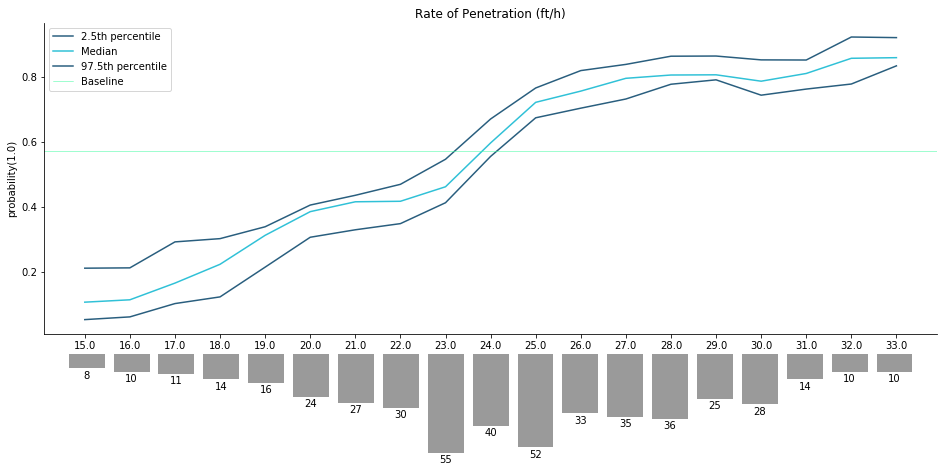

In [31]:
SimulationDrawer().draw(data=rop_simulation, title=SIM_FEATURE)

# Summary

*This section should list the key conclusions/takeaways from the tutorial.*

# What can you do next?

*If applicable this section should note what readers of the tutorial can think about or do next to extend what was done or develop the skills taught further.*

# Appendix

*The Appendix should detail all relevant information to the tutorial not included in the main outline above. It should include at a minimum the two sections below.*

## Data source and study cohort

*This section should include all information relevant to obtaining the data used in the tutorial and reproducing the starting point for the tutorial. This could include things like:* 

1. *Detailed listings of data sources, including links and how to access*  
2. *How the study population are defined, whether it be all transactions over a certain value or all patients above a certain age*  
3. *If any features or the target require definitions in order to be derived from the data, such as the combination of levels in biomarkers*
4. *Any other information pertinent to the reproducibility of the tutorial*

## Exploratory Data Analysis (EDA)

*This section should perform two functions:*  

1. *To walk the reader through the EDA behind the tutorial, and*  
2. *Provide a quick summary of EDA conclusions relevant to the tutorial which could include items such as identifying missingness, then need for transformations or outlier mitigation, basic associations between features and the target, etc*